# Automated credit model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce

import statsmodels.api as sm
from linearmodels.panel import PanelOLS

from macrobond_ram import c_macrobond as m_macrobond
from macrobond_api_constants import SeriesFrequency as f

In [2]:
def get_data(tickers, column_names, data_freq):
    
    freq_map = {
        'D': f.DAILY,
        'W': f.WEEKLY,
        'M': f.MONTHLY,
        'Q': f.QUARTERLY,
        'A': f.ANNUAL,
        'H': f.HIGHEST
    }
    
    ticks_new = [x.lower() for x in tickers]
    mb = m_macrobond.Macrobond()
    dat = mb.CreateUnifiedSeriesRequst(ticker_list=ticks_new, 
                                       Frequency=freq_map.get(data_freq))
    dat = dat.asfreq(freq=data_freq)
    dat.columns = column_names
    return dat

In [3]:
asset_table = pd.read_excel('credit_spread_data_book.xlsx', sheet_name='assets',
                              header=0, index_col=0)

country_table = pd.read_excel('credit_spread_data_book.xlsx', sheet_name='country',
                               header=1, index_col=0, dtype=str)

region_table = pd.read_excel('credit_spread_data_book.xlsx', sheet_name='region',
                             header=1, index_col=0, dtype=str)

In [4]:
"""
asset_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='assets',
                              header=0, index_col=0)

country_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='country',
                               header=1, index_col=0, dtype=str)

region_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='region',
                             header=1, index_col=0, dtype=str)
"""

"\nasset_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='assets',\n                              header=0, index_col=0)\n\ncountry_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='country',\n                               header=1, index_col=0, dtype=str)\n\nregion_table = pd.read_excel('credit_spread_data_book.xlsx', engine='openpyxl', sheet_name='region',\n                             header=1, index_col=0, dtype=str)\n"

In [5]:
# lots of countries without tickers, lets focus on countries with tickers for all variables
havealltickers = country_table.loc[:, country_table.columns!='GSTOT'].isna().apply(lambda x: (x==False).all(), axis=1)

# lets also delete Russia as embig data looks discontinued
havealltickers['Russia'] = False

country_table_new = country_table[havealltickers]

In [6]:
# for reference, countries where we have tickers for all variables...
print(country_table[havealltickers].index.tolist())

['Argentina', 'Armenia', 'Belarus', 'Bolivia', 'Brazil', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Georgia', 'Guatemala', 'Hungary', 'India', 'Indonesia', 'Jamaica', 'Jordan', 'Kazakhstan', 'Lithuania', 'Mexico', 'Mongolia', 'Morocco', 'Namibia', 'Nigeria', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Slovakia', 'South Africa', 'Sri Lanka', 'Suriname', 'Tajikistan', 'Trinidad & Tobago', 'Turkey', 'Ukraine', 'Uruguay']


In [7]:
# ... and countries where we are missing some tickers
print(country_table[~havealltickers].index.tolist())

['Angola', 'Azerbaijan', 'Bahrain', 'Belize', 'Bulgaria', 'Cameroon', "Cote D'Ivoire", 'Czech Republic', 'Ethiopia', 'Gabon', 'Ghana', 'Honduras', 'Hong Kong', 'Iraq', 'Israel', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Malaysia', 'Mozambique', 'Oman', 'Papua New Guinea', 'Qatar', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'South Korea', 'Thailand', 'Tunisia', 'UAE', 'Venezuela', 'Vietnam', 'Zambia']


In [8]:
# extract tickers
tck_embig = country_table_new['EMBIG']
tck_gstot = country_table_new['GSTOT'].dropna()
tck_cpi = country_table_new['CPI']
tck_tot = country_table_new['TOT']
tck_res = country_table_new['RES']
tck_iip = country_table_new['IIP']
tck_ltdebt = country_table_new['LTDEBT']
tck_stdebt = country_table_new['STDEBT']
tck_ngdp = country_table_new['NGDP']
tck_pdebt = country_table_new['PDEBT']
tck_ca = country_table_new['CA']
tck_rgdp = country_table_new['RGDP']

In [9]:
# query daily data
df_embig = get_data(tck_embig.tolist(), tck_embig.index, 'D')
df_gstot = get_data(tck_gstot.tolist(), tck_gstot.index, 'D')
df_assets = get_data(asset_table['Ticker'].tolist(), asset_table.index.tolist(), 'D')

In [10]:
# temporary fix... set zeros and negatives to a small number log(0) indeterminate
df_embig[df_embig==0] = 0.00001
df_embig[df_embig<0] = 0.00001

In [11]:
# query monthly data
df_cpi = get_data(tck_cpi.tolist(), tck_cpi.index, 'M')
df_tot = get_data(tck_tot.tolist(), tck_tot.index, 'M')

In [12]:
# query quarterly data
df_res = get_data(tck_res.tolist(), tck_res.index, 'Q')
df_iip = get_data(tck_iip.tolist(), tck_iip.index, 'Q')
df_ltdebt = get_data(tck_ltdebt.tolist(), tck_ltdebt.index, 'Q')
df_stdebt = get_data(tck_stdebt.tolist(), tck_stdebt.index, 'Q')
df_regions = get_data(region_table['RGDP'].tolist(), region_table.index, 'Q')

In [13]:
# query annual data
df_ngdp = get_data(tck_ngdp.tolist(), tck_ngdp.index, 'A')
df_pdebt = get_data(tck_pdebt.tolist(), tck_pdebt.index, 'A')
df_ca = get_data(tck_ca.tolist(), tck_ca.index, 'A')
df_rgdp = get_data(tck_rgdp.tolist(), tck_rgdp.index, 'A')

In [14]:
df_iip = get_data(tck_iip.tolist(), tck_iip.index, 'Q')
df_iip['Argentina']

1980-03-31             NaN
1980-06-30             NaN
1980-09-30             NaN
1980-12-31             NaN
1981-03-31             NaN
                  ...     
2021-06-30    1.270859e+11
2021-09-30    1.229595e+11
2021-12-31    1.222465e+11
2022-03-31    1.193429e+11
2022-06-30             NaN
Freq: Q-DEC, Name: Argentina, Length: 170, dtype: float64

In [15]:
# sum of ST and LT debt
if (df_ltdebt.columns==df_ltdebt.columns).all():
    df_totdebt = df_stdebt + df_ltdebt
else:
    print('Mismatch of country debt data.')

In [16]:
# resample daily asset prices, yields and GS terms of trade to monthly average
# NB. if we are not yet at the end of a month, this will still produce an average value for that month using partial data
# e.g. today is 05/10/2022, we will have an observation for 31/10/2022 using average of 01/10/2022 - 05/10/2022 data
df_embig = df_embig.resample('1M').mean()
df_gstot = df_gstot.resample('1M').mean()
df_assets = df_assets.resample('1M').mean()

In [17]:
df_embig

Country,Argentina,Armenia,Belarus,Bolivia,Brazil,Chile,China,Colombia,Costa Rica,Croatia,...,Romania,Slovakia,South Africa,Sri Lanka,Suriname,Tajikistan,Trinidad & Tobago,Turkey,Ukraine,Uruguay
1993-12-31,352.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-31,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-02-28,382.473684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-31,581.782609,NaN,NaN,NaN,NaN,NaN,126.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-04-30,755.526316,NaN,NaN,NaN,1127.000000,NaN,131.421053,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,2150.523810,476.847762,NaN,603.095238,322.285714,178.952381,188.714286,388.809524,439.142857,90.095238,...,288.571429,NaN,427.333333,4181.095238,1618.881048,1599.580762,322.095238,636.809524,3904.238095,146.666667
2022-07-31,2701.900000,562.059600,NaN,662.750000,344.950000,200.200000,195.300000,437.700000,512.000000,61.850000,...,334.550000,NaN,511.200000,6102.050000,1712.108400,1927.108300,350.400000,744.450000,6339.900000,157.750000
2022-08-31,2417.434783,507.686391,NaN,636.217391,297.695652,186.086957,195.000000,400.260870,449.695652,15.956523,...,269.086957,NaN,412.869565,5311.086957,1755.978435,1788.349783,264.565217,628.565217,5379.869565,131.173913
2022-09-30,2450.380952,464.425667,NaN,578.904762,286.238095,193.619048,186.000000,423.571429,429.666667,54.714286,...,309.904762,NaN,436.142857,6025.190476,1516.520286,1653.560000,214.238095,605.095238,3646.333333,137.952381


In [18]:
# extend monthly IMF terms of trade with more timely daily GS terms of trade
end = df_tot.index[-1]  # get last date

# get only new data from GS whilst rebasing to end of IMF date to give future multiplication factors
factors = df_gstot[df_gstot.index>end]/df_gstot[df_gstot.index==end].values
df_totextended = pd.DataFrame(index=df_tot.index.append(factors.index), columns=df_tot.columns)  # new data frame with all dates
df_totextended.loc[df_tot.index, :] = df_tot.loc[:, :]  # copy over imf data
df_totextended.loc[factors.index, factors.columns] = (factors*df_tot.loc[end, factors.columns]).loc[:, :]  # multiply end of IMF data by future factors
df_totextended.tail(6)

Country,Argentina,Armenia,Belarus,Bolivia,Brazil,Chile,China,Colombia,Costa Rica,Croatia,...,Romania,Slovakia,South Africa,Sri Lanka,Suriname,Tajikistan,Trinidad & Tobago,Turkey,Ukraine,Uruguay
2022-05-31,100.055,97.5643,96.8115,112.662,99.6026,103.178,99.9865,102.066,100.768,99.0993,...,100.263,98.4395,101.035,99.047,98.3969,99.4823,106.334,99.3733,97.8062,101.443
2022-06-30,99.8288,96.8066,96.3673,114.883,99.5157,102.231,99.9364,102.336,100.601,98.8829,...,100.165,98.0658,100.837,98.9676,98.2834,99.034,108.331,99.3788,96.2823,101.19
2022-07-31,99.431,95.3511,94.838,120.247,99.1406,99.5731,100.462,101.687,101.01,99.038,...,100.26,97.886,100.795,99.5453,98.7592,99.1984,111.318,99.7444,93.7666,100.978
2022-08-31,NaN,NaN,NaN,NaN,99.1624,100.671,100.44,101.4,NaN,NaN,...,NaN,NaN,101.146,NaN,NaN,NaN,NaN,99.6325,93.6602,NaN
2022-09-30,NaN,NaN,NaN,NaN,98.9601,100.248,100.725,101.117,NaN,NaN,...,NaN,NaN,101.094,NaN,NaN,NaN,NaN,99.6824,94.4089,NaN
2022-10-31,NaN,NaN,NaN,NaN,98.8714,99.9743,100.811,101.107,NaN,NaN,...,NaN,NaN,100.94,NaN,NaN,NaN,NaN,99.7489,94.8916,NaN


In [19]:
"""
# resample annual NGDP data to monthly
# how? forward fill same value or linear interpolation?
fig, ax = plt.subplots()
ax.plot(df_ngdp.resample('1M').ffill()['Brazil'], label='Forward fill')
ax.plot(df_ngdp.resample('1M').interpolate()['Brazil'], label='Interpolation')
ax.legend()
ax.grid()
ax.set_title('Brazilian NGDP')
plt.tight_layout()
plt.show()
"""

"\n# resample annual NGDP data to monthly\n# how? forward fill same value or linear interpolation?\nfig, ax = plt.subplots()\nax.plot(df_ngdp.resample('1M').ffill()['Brazil'], label='Forward fill')\nax.plot(df_ngdp.resample('1M').interpolate()['Brazil'], label='Interpolation')\nax.legend()\nax.grid()\nax.set_title('Brazilian NGDP')\nplt.tight_layout()\nplt.show()\n"

In [20]:
'''
# resample quarterly International Reserves data to monthly
# how? forward fill same value or linear interpolation?
fig, ax = plt.subplots()
ax.plot(df_res.resample('1M').ffill()['Brazil'], label='Forward fill')
ax.plot(df_res.resample('1M').interpolate()['Brazil'], label='Interpolation')
ax.legend()
ax.grid()
ax.set_title('Brazilian International Reserves')
plt.tight_layout()
plt.show()
'''

"\n# resample quarterly International Reserves data to monthly\n# how? forward fill same value or linear interpolation?\nfig, ax = plt.subplots()\nax.plot(df_res.resample('1M').ffill()['Brazil'], label='Forward fill')\nax.plot(df_res.resample('1M').interpolate()['Brazil'], label='Interpolation')\nax.legend()\nax.grid()\nax.set_title('Brazilian International Reserves')\nplt.tight_layout()\nplt.show()\n"

In [21]:
"""
# as in we evetually want to calculate international reserves (Q) as percentage of nominal gdp (A)
fig, ax = plt.subplots()
df_res['Brazil'].resample('1M').ffill().divide(df_ngdp['Brazil'].resample('1M').ffill()).ffill().plot(ax=ax, label='fill()')
df_res['Brazil'].resample('1M').interpolate().divide(df_ngdp['Brazil'].resample('1M').interpolate()).plot(ax=ax, label='interpolate()')
ax.legend()
ax.grid()
ax.set_title("International Reserves to GDP")
plt.tight_layout()
plt.show()
"""

'\n# as in we evetually want to calculate international reserves (Q) as percentage of nominal gdp (A)\nfig, ax = plt.subplots()\ndf_res[\'Brazil\'].resample(\'1M\').ffill().divide(df_ngdp[\'Brazil\'].resample(\'1M\').ffill()).ffill().plot(ax=ax, label=\'fill()\')\ndf_res[\'Brazil\'].resample(\'1M\').interpolate().divide(df_ngdp[\'Brazil\'].resample(\'1M\').interpolate()).plot(ax=ax, label=\'interpolate()\')\nax.legend()\nax.grid()\nax.set_title("International Reserves to GDP")\nplt.tight_layout()\nplt.show()\n'

In [22]:
# resample annual nominal gdp to monthly
df_ngdp = df_ngdp.resample('1M').ffill()

# resample quarterly reserves to monthly
df_res = df_res.resample('1M').ffill()

countries = df_ngdp.columns.intersection(df_res.columns)
df_res2gdp = (df_res[countries].divide(df_ngdp[countries]))*(100/8.147950956)
#df_res2gdp_intp = df_res.resample('1M').interpolate()[countries].divide(df_ngdp.resample('1M').interpolate()[countries])

In [23]:
# resample rest of quarterly data to monthly (Investment Position, TOTAL DEBT)
df_iip = df_iip.resample('1M').ffill()
df_totdebt = df_totdebt.resample('1M').ffill()

In [24]:
# resample rest of annual data to monthly (Public Debt, Current account, GDP growth)
df_pdebt = df_pdebt.resample('1M').ffill()
df_ca = df_ca.resample('1M').ffill()
df_rgdp = df_rgdp.resample('1M').ffill()

In [25]:
# have iip listed as a share of GDP
df_iip = (df_iip/df_ngdp)*100

In [26]:
# aggregate global growth
# need tobe careful on this, the regions have different start dates.
# if you use the whole series, you assume US growth is global growth pre 1996 (EU and China data start about here)
df_globalgrowth = (df_regions.resample('1M').ffill().pct_change(12).mean(axis=1))*100

In [27]:
# transform CPI and GDP to YoY%
df_cpi = (df_cpi.pct_change(12))*100
df_rgdp = (df_rgdp.pct_change(12))*100
df_cpi

Country,Argentina,Armenia,Belarus,Bolivia,Brazil,Chile,China,Colombia,Costa Rica,Croatia,...,Romania,Slovakia,South Africa,Sri Lanka,Suriname,Tajikistan,Trinidad & Tobago,Turkey,Ukraine,Uruguay
1937-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1937-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1937-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1937-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1937-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,60.679930,0.517438,17.005966,1.414449,11.731213,11.545179,1.978461,9.059169,8.714148,10.803059,...,0.646573,12.555310,6.611570,45.334262,57.467779,0.188980,4.886878,73.495950,18.026876,9.374865
2022-06-30,63.982582,1.181961,17.563246,1.792156,11.886870,12.490816,2.388013,9.680088,10.055606,12.045889,...,0.488681,13.256326,7.415036,58.888126,55.099247,0.733816,4.873646,78.618397,21.458947,9.287034
2022-07-31,71.002454,-0.864030,18.068942,2.038856,10.069403,13.119534,2.592176,10.197911,11.480083,12.309160,...,-0.079231,13.628900,8.053007,66.712142,49.222798,-0.029872,5.924596,79.602053,22.189542,9.559641
2022-08-31,78.515273,-0.176433,17.916756,1.547838,8.727291,14.089877,2.387197,10.837438,12.128482,12.285714,...,0.319234,14.067612,7.918782,70.224337,39.088799,-0.119379,5.734767,80.207594,23.772102,9.534105


In [28]:
# take logs of embig
df_embig = df_embig.apply(np.log)

In [29]:
# amend df_globalgrowth and df_assets to conform to our data 
df_vix = pd.DataFrame([df_assets['VIX'].values for x in df_embig.columns], index=df_embig.columns, columns=df_assets.index).T
df_dxy = pd.DataFrame([df_assets['DXY'].values for x in df_embig.columns], index=df_embig.columns, columns=df_assets.index).T
df_glblgrowth = pd.DataFrame([df_globalgrowth.values for x in df_embig.columns], index=df_embig.columns, columns=df_globalgrowth.index).T

In [30]:
# we need to make sure variables have common dates and no NANs
dfs = [df_embig, df_totextended, df_cpi, df_res, df_iip, df_ngdp, df_pdebt,
       df_ca, df_totdebt, df_res2gdp, df_vix, df_dxy, df_glblgrowth, df_rgdp]

dfnames = ['embig', 'termsoftrade', 'cpi', 'reserves', 'intlinvestment',
           'nominalgdp', 'publicdebt', 'currentaccount', 'totaldebt',
           'reserveratio', 'vix', 'dollar', 'globalgrowth', 'realgrowth']

# find the first date in each variable where we have observations for all countries
# potentiall do away with this as can ahve unbalanced panel
# BUT still need to get rid of nans...
#valid_dates = [x.apply(lambda x: x.first_valid_index()).max() for x in dfs]
#common_start_date = max(valid_dates)
#dfs = [df.loc[common_start_date:, :] for df in dfs]

In [31]:
# just checking our data all have same frequency
[df.index.freq for df in dfs]

[<MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>,
 <MonthEnd>]

In [32]:
# for reference, here are the variables and common start dates
# cpi is really holding back a longer history of observtations
# which country??
# list(zip(valid_dates, dfnames))

In [33]:
# Buy you a beer if you find a better way of doing this!
# Transform dataframe structure to panel data format
def createpaneldata(dfs, names):
    melted = []
    for df, name in zip(dfs, names):
        df = df.melt(ignore_index=False, value_name=name)
        df = df.set_index([df['Country'], df.index])
        df.index.names = ['country', 'date']
        df = df.drop('Country', axis=1)
        melted.append(df)
        
    df_merged = reduce(lambda left, right: pd.merge(left, right,
                                                    left_index=True, right_index=True), melted)
        
    return df_merged

regdata = createpaneldata(dfs, dfnames)
regdata
regdata.to_csv("regdata.csv")

In [34]:
# just a random regression just so we can test
# definitely should compare against eviews
# also the output tells us we have missing observations, so the checks we did above aren't complete...
"""
exog_vars = ['termsoftrade', 'cpi', 'reserves', 'intlinvestment',
             'nominalgdp', 'publicdebt', 'currentaccount', 'totaldebt',
             'reserveratio', 'vix', 'dollar', 'globalgrowth', 'realgrowth']
"""

exog_vars = ['cpi', 'currentaccount', 'realgrowth', 'globalgrowth', 'intlinvestment',
             'publicdebt', 'reserveratio','termsoftrade', 'vix']

exog = sm.add_constant(regdata[exog_vars])
mod = PanelOLS(regdata['embig'], exog, entity_effects=True, time_effects=False, check_rank=False)
fe_res = mod.fit(cov_type='robust')
fe_res.summary

C:\Users\MR99924\AppData\Roaming\Python\Python37\site-packages\linearmodels\shared\exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,embig,R-squared:,0.0784
Estimator:,PanelOLS,R-squared (Between):,0.2610
No. Observations:,6038,R-squared (Within):,0.0784
Date:,"Tue, Oct 18 2022",R-squared (Overall):,0.1312
Time:,16:53:07,Log-likelihood,-8254.6
Cov. Estimator:,Robust,,
,,F-statistic:,56.532
Entities:,44,P-value,0.0000
Avg Obs:,137.23,Distribution:,"F(9,5985)"
Min Obs:,12.000,,
Max Obs:,286.00,F-statistic (robust):,90.416


In [35]:
fe_res.estimated_effects

estimated_effects
country   date                         
Argentina 2017-12-31           0.692894
          2018-01-31           0.692894
          2018-02-28           0.692894
          2018-03-31           0.692894
          2018-04-30           0.692894
...                                 ...
Uruguay   2021-08-31          -0.037786
          2021-09-30          -0.037786
          2021-10-31          -0.037786
          2021-11-30          -0.037786
          2021-12-31          -0.037786

[6038 rows x 1 columns]

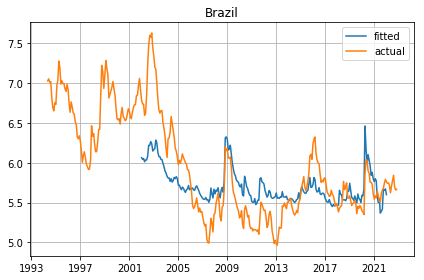

In [36]:
fig, ax = plt.subplots()
ax.plot(fe_res.fitted_values.loc['Brazil'], label='fitted')
ax.plot(df_embig['Brazil'], label='actual')
ax.grid()
ax.legend()
ax.set_title('Brazil')
plt.tight_layout()
plt.show()

In [44]:
"""
df_cpi - missing end dates
df_res - missing end dates, Nigeria, Peru nans
df_iip - missing end dates, China, India, Mexico, Nigeria, Phillipines, Poland, South Africa waiting for next release
df_ngdp - missing lots of end dates
df_pdebt - has forecasts, but ukraine missing some data
df_ca - has forecasts, but ukraine missing some data
df_totdebt - missing end dates, Brazil, Nigeria, also missing extra data
df_glblgrowth - missing end data
"""

'\ndf_cpi - missing end dates\ndf_res - missing end dates, Nigeria, Peru nans\ndf_iip - missing end dates, China, India, Mexico, Nigeria, Phillipines, Poland, South Africa waiting for next release\ndf_ngdp - missing lots of end dates\ndf_pdebt - has forecasts, but ukraine missing some data\ndf_ca - has forecasts, but ukraine missing some data\ndf_totdebt - missing end dates, Brazil, Nigeria, also missing extra data\ndf_glblgrowth - missing end data\n'

In [35]:
fe_res.fitted_values.loc['Brazil']

,fitted_values
date,
2001-12-31,6.120855
2002-01-31,6.083165
2002-02-28,6.099201
2002-03-31,6.037261
2002-04-30,6.072631
...,...
2021-08-31,4.510081
2021-09-30,4.297421
2021-10-31,4.262957


In [36]:
df_embig['Brazil']

1993-12-31         NaN
1994-01-31         NaN
1994-02-28         NaN
1994-03-31         NaN
1994-04-30    7.027315
                ...   
2022-06-30    5.775438
2022-07-31    5.843399
2022-08-31    5.696072
2022-09-30    5.656824
2022-10-31    5.667464
Freq: M, Name: Brazil, Length: 347, dtype: float64

In [214]:
pd.set_option('display.max_rows', None)

In [141]:
pd.set_option('display.max_columns', 10)